# Yelp
The objective is to automatically tags restaurants with multiple labels. The labels are,
* 0: good_for_lunch
* 1: good_for_dinner
* 2: takes_reservations
* 3: outdoor_seating
* 4: restaurant_is_expensive
* 5: has_alcohol
* 6: has_table_service
* 7: ambience_is_classy
* 8: good_for_kids

#### Strategy
Since there are 9 different labels (tags), we'll train 9 different models, each dedicated to one label.

We begin by importing some standard Python libraries

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import os
from skimage import io, novice
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle
import cv2
from PIL import Image
import PIL

TRAIN_DIR = './train_photos'
TEST_DIR = './test_photos'

TRAIN_SAVE = './train_img/'
TRAIN_LABEL = './train_label/'

TEST_SAVE = './test_img/'

IMG_SIZE = (75, 75)

## Dataset
* __train_photos__ - directory whihch contains photos of the training set
* __test_photos__ - directory which contains photos of the test set
* __train_photo_to_biz_ids.csv__ - maps the photo id to business id
* __test_photo_to_biz_ids.csv__ - maps the photo id to business id
* __train.csv__ - main training dataset. Includes the business id's, and their corresponding labels. 
* __sample_submission.csv__ - sample submission and the test dataset. This is the correct format for your predictions. It should include the business_id and the corresponding predicted labels.

In [2]:
training_imgs = list()
testing_imgs = list()
good_for_lunch = list()
good_for_dinner = list()
takes_reservations = list()
outdoor_seating = list()
restaurant_is_expensive = list()
has_alcohol = list()
has_table_service = list()
ambience_is_classy = list()
good_for_kids = list()

train_photo_to_biz_ids = pd.read_csv('train_photo_to_biz_ids.csv', names=['photo_id', 'business_id'])
train_photo_to_biz_ids = train_photo_to_biz_ids.set_index('photo_id')

test_photo_to_biz_ids = pd.read_csv('test_photo_to_biz.csv', names=['photo_id', 'business_id'])
test_photo_to_biz_ids = test_photo_to_biz_ids.set_index('photo_id')

biz_ids_to_labels = pd.read_csv('train.csv', names=['business_id', 'labels'])
biz_ids_to_labels = biz_ids_to_labels.set_index('business_id')

def read_images(training_imgs, testing_imgs, 
                good_for_lunch, good_for_dinner, 
                takes_reservations, outdoor_seating, 
                restaurant_is_expensive, has_alcohol, 
                has_table_service, ambience_is_classy, 
                good_for_kids, is_testing=False):
    i = 0
    f_id = 0
    
    if is_testing == False:
        print('Reading training data...')
        for img in tqdm(os.listdir(TRAIN_DIR)):
            f_name = os.path.splitext(img)[0]
            f_name = f_name.replace('.', '')
            f_name = f_name.replace('_', '')
            biz_id = train_photo_to_biz_ids.get_value(f_name, 'business_id')
            labels = str(biz_ids_to_labels.get_value(biz_id, 'labels'))
            
            one_hot(list(labels), 
                    good_for_lunch, 
                    good_for_dinner, 
                    takes_reservations, 
                    outdoor_seating, 
                    restaurant_is_expensive, 
                    has_alcohol, 
                    has_table_service, 
                    ambience_is_classy, 
                    good_for_kids)
            
            ext = os.path.splitext(img)[1]
            training_path = os.path.join(TRAIN_DIR, f_name + ext)
            img = cv2.imread(training_path)
                
            height, width = img.shape[:2]
            if height != IMG_SIZE[0] or width != IMG_SIZE[1]:
                img = cv2.resize(img, IMG_SIZE)                
            img = np.array(img) / 255.
            

            training_imgs.append(img)
            
            if (i == 23484 or i == 46968 or i == 70452 or 
                i == 93936 or i == 117420 or i == 140904 or 
                i == 164388 or i == 187872 or i == 211356 or 
                i == 234842 or i == 258326 or i == 281810 or 
                i == 305294 or i == 328778 or i == 352262 or 
                i == 375746 or i == 399230 or i == 422714 or 
                i == 446198 or i == 469682 or i == 493166 or 
                i == 516650 or i == 540134 or i == 563618):
                
                print('Saving training_' + str(f_id) + '.npy to disk')
                
                training_imgs = np.array(training_imgs)                
                np.save(TRAIN_SAVE + 'training_' + str(f_id) + '.npy', training_imgs)
                training_imgs = list()
                    
                good_for_lunch = np.array(good_for_lunch)
                np.save(TRAIN_LABEL + 'good_for_lunch_' + str(f_id) + '.npy', good_for_lunch)
                good_for_lunch = list()
        
                good_for_dinner = np.array(good_for_dinner)
                np.save(TRAIN_LABEL + 'good_for_dinner_' + str(f_id) + '.npy', good_for_dinner)
                good_for_dinner = list()
        
                takes_reservations = np.array(takes_reservations)
                np.save(TRAIN_LABEL + 'takes_reservations_' + str(f_id) + '.npy', takes_reservations)
                takes_reservations = list()
        
                outdoor_seating = np.array(outdoor_seating)
                np.save(TRAIN_LABEL + 'outdoor_seating_' + str(f_id) + '.npy', outdoor_seating)
                outdoor_seating = list()
        
                restaurant_is_expensive = np.array(restaurant_is_expensive)
                np.save(TRAIN_LABEL + 'restaurant_is_expensive_' + str(f_id) + '.npy', restaurant_is_expensive)
                restaurant_is_expensive = list()
        
                has_alcohol = np.array(has_alcohol)
                np.save(TRAIN_LABEL + 'has_alcohol_' + str(f_id) + '.npy', has_alcohol)
                has_alcohol = list()
        
                has_table_service = np.array(has_table_service)
                np.save(TRAIN_LABEL + 'has_table_service_' + str(f_id) + '.npy', has_table_service)
                has_table_service = list()
        
                ambience_is_classy = np.array(ambience_is_classy)
                np.save(TRAIN_LABEL + 'ambience_is_classy_' + str(f_id) + '.npy', ambience_is_classy)
                ambience_is_classy = list()
        
                good_for_kids = np.array(good_for_kids)
                np.save(TRAIN_LABEL + 'good_for_kids_' + str(f_id) + '.npy', good_for_kids)
                good_for_kids = list()
                
                f_id += 1                
                
            i += 1

    else:
        print('Reading testing data...')
        for img in tqdm(os.listdir(TEST_DIR)):
            f_name = os.path.splitext(img)[0]
            f_name = f_name.replace('.', '')
            f_name = f_name.replace('_', '')
            
            ext = os.path.splitext(img)[1]
            testing_path = os.path.join(TEST_DIR, f_name + ext)
            img = cv2.imread(testing_path)
                
            height, width = img.shape[:2]
            if height != IMG_SIZE[0] or width != IMG_SIZE[1]:
                img = cv2.resize(img, IMG_SIZE)                
            img = np.array(img) / 255.
            

            testing_imgs.append(img)
            
            if (i == 23484 or i == 46968 or i == 70452 or 
                i == 93936 or i == 117420 or i == 140904 or 
                i == 164388 or i == 187872 or i == 211356 or 
                i == 234842 or i == 258326 or i == 281810 or 
                i == 305294 or i == 328778 or i == 352262 or 
                i == 375746 or i == 399230 or i == 422714 or 
                i == 446198 or i == 469682 or i == 493166 or 
                i == 516650 or i == 540134 or i == 563618):
                
                print('Saving testing_' + str(f_id) + '.npy to disk')
                testing_imgs = np.array(testing_imgs)
                
                np.save(TEST_SAVE + 'testing_' + str(f_id) + '.npy', testing_imgs)
                testing_imgs = list()
            
                f_id += 1
                
            i += 1
        
def one_hot(labels, good_for_lunch, good_for_dinner, takes_reservations, outdoor_seating, 
            restaurant_is_expensive, has_alcohol, has_table_service, ambience_is_classy, good_for_kids):
    if '0' in labels:
        good_for_lunch.append(np.array([1, 0]))
    else:
        good_for_lunch.append(np.array([0, 1]))
        
    if '1' in labels:
        good_for_dinner.append(np.array([1, 0]))
    else:
        good_for_dinner.append(np.array([0, 1]))
        
    if '2' in labels:
        takes_reservations.append(np.array([1, 0]))
    else:
        takes_reservations.append(np.array([0, 1]))
        
    if '3' in labels:
        outdoor_seating.append(np.array([1, 0]))
    else:
        outdoor_seating.append(np.array([0, 1]))
        
    if '4' in labels:
        restaurant_is_expensive.append(np.array([1, 0]))
    else:
        restaurant_is_expensive.append(np.array([0, 1]))
        
    if '5' in labels:
        has_alcohol.append(np.array([1, 0]))
    else:
        has_alcohol.append(np.array([0, 1]))
        
    if '6' in labels:
        has_table_service.append(np.array([1, 0]))
    else:
        has_table_service.append(np.array([0, 1]))
        
    if '7' in labels:
        ambience_is_classy.append(np.array([1, 0]))
    else:
        ambience_is_classy.append(np.array([0, 1]))
        
    if '8' in labels:
        good_for_kids.append(np.array([1, 0]))
    else:
        good_for_kids.append(np.array([0, 1]))
        
def is_training_file_present():
    return (
        os.path.isfile(TRAIN_SAVE + 'training_0.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_1.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_2.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_3.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_4.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_5.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_6.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_7.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_8.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_9.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_10.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_11.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_12.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_13.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_14.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_15.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_16.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_17.npy') == False or 
        os.path.isfile(TRAIN_SAVE + 'training_18.npy') == False or os.path.isfile(TRAIN_SAVE + 'training_19.npy') == False
    )

def is_training_label_present():
    return (
        # check availability of good_for_lunch labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_lunch_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_lunch_19.npy') == False or 
        
        # check availability of good_for_dinner labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_dinner_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_dinner_19.npy') == False or 
        
        # check availability of takes_reservations labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'takes_reservations_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'takes_reservations_19.npy') == False or 
        
        # check availability of outdoor_seating labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'outdoor_seating_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'outdoor_seating_19.npy') == False or 
        
        # check availability of restaurant_is_expensive labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'restaurant_is_expensive_19.npy') == False or 
        
        # check availability of has_alcohol labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_alcohol_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_alcohol_19.npy') == False or 
        
        # check availability of has_table_service labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'has_table_service_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'has_table_service_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'has_table_service_19.npy') == False or 
        
        # check availability of ambience_is_classy labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'ambience_is_classy_19.npy') == False or 
        
        # check availability of good_for_kids labels in our ./train_label directory
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_0.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_1.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_2.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_3.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_4.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_5.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_6.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_7.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_8.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_9.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_10.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_11.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_12.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_13.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_14.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_15.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_16.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_17.npy') == False or 
        os.path.isfile(TRAIN_LABEL + 'good_for_kids_18.npy') == False or os.path.isfile(TRAIN_LABEL + 'good_for_kids_19.npy') == False
    )

def is_testing_file_present():
    return (
        os.path.isfile(TEST_SAVE + 'testing_0.npy') == False or os.path.isfile(TEST_SAVE + 'testing_1.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_2.npy') == False or os.path.isfile(TEST_SAVE + 'testing_3.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_4.npy') == False or os.path.isfile(TEST_SAVE + 'testing_5.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_6.npy') == False or os.path.isfile(TEST_SAVE + 'testing_7.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_8.npy') == False or os.path.isfile(TEST_SAVE + 'testing_9.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_10.npy') == False or os.path.isfile(TEST_SAVE + 'testing_11.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_12.npy') == False or os.path.isfile(TEST_SAVE + 'testing_13.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_14.npy') == False or os.path.isfile(TEST_SAVE + 'testing_15.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_16.npy') == False or os.path.isfile(TEST_SAVE + 'testing_17.npy') == False or 
        os.path.isfile(TEST_SAVE + 'testing_18.npy') == False or os.path.isfile(TEST_SAVE + 'testing_19.npy') == False
    )
        

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Insufficient RAM
Due to insufficient memory, we are dividing the training data and their labels into 19 chunks. These chunks are saved as *__pickle__* files on to disk. 

In [3]:
if is_training_file_present() and is_training_label_present():
    
    read_images(training_imgs, testing_imgs, 
                good_for_lunch, good_for_dinner, 
                takes_reservations, outdoor_seating, 
                restaurant_is_expensive, has_alcohol, 
                has_table_service, ambience_is_classy, 
                good_for_kids)
else:
    # Load pickle files from disk
    
    print('Reading training data from pickle files....')
    
#     pickle_in = pickle.open('training.pickle', 'rb')
#     training_imgs = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('good_for_lunch.pickle', 'rb')
#     good_for_lunch = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('good_for_dinner.pickle', 'rb')
#     good_for_dinner = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('takes_reservations.pickle', 'rb')
#     takes_reservations = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('outdoor_seating.pickle', 'rb')
#     outdoor_seating = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('restaurant_is_expensive.pickle', 'rb')
#     restaurant_is_expensive = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('has_table_service.pickle', 'rb')
#     has_table_service = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('has_alcohol.pickle', 'rb')
#     has_alcohol = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('ambience_is_classy.pickle', 'rb')
#     ambience_is_classy = pickle.load(pickle_in)
#     pickle_in.close()
    
#     pickle_in = pickle.open('good_for_kids.pickle', 'rb')
#     good_for_kids = pickle.load(pickle_in)
#     pickle_in.close()
    
if is_testing_file_present():
    
    read_images(training_imgs, testing_imgs, 
                good_for_lunch, good_for_dinner, 
                takes_reservations, outdoor_seating, 
                restaurant_is_expensive, has_alcohol, 
                has_table_service, ambience_is_classy, 
                good_for_kids, is_testing=True)
    
# else:
#     # Load testing data from disk
#     print('Reading testing data from pickle files....')
    
#     pickle_in = pickle.open('testing.pickle', 'rb')
#     testing_imgs = pickle.load(pickle_in)
#     pickle_in.close()

Reading training data from pickle files....


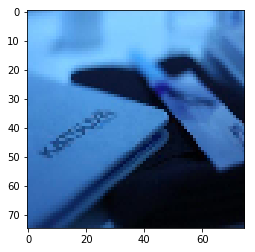

[0 1]


In [4]:
training_imgs = list()
training_imgs = np.load(TRAIN_SAVE + 'training_0.npy')

good_for_lunch = list()
good_for_lunch = np.load(TRAIN_LABEL + 'good_for_lunch_0.npy')
    
plt.imshow(training_imgs[5])
plt.show()
print(good_for_lunch[5])
total_imgs = training_imgs.shape[0]

### Input

The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement neural_net_image_input
    * Return a TF Placeholder
    * Set the shape using `image_shape` with batch size set to None.
    * Name the TensorFlow placeholder "x" using the TensorFlow name parameter in the TF Placeholder.
* Implement neural_net_label_input
    * Return a TF Placeholder
    * Set the shape using n_classes with batch size set to None.
    * Name the TensorFlow placeholder "y" using the TensorFlow name parameter in the TF Placeholder.
* Implement neural_net_keep_prob_input
    * Return a TF Placeholder for dropout keep probability.
    * Name the TensorFlow placeholder "keep_prob" using the TensorFlow name parameter in the TF Placeholder.
    * These names will be used at the end of the project to load your saved model.

Note: _None_ for shapes in TensorFlow allow for a dynamic size.

In [5]:
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, [None] + list(image_shape), 'x')

def neural_net_label_input(n_classes = 2):
    return tf.placeholder(tf.float32, (None, n_classes), 'y')

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, None, 'keep_prob')

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function conv2d_maxpool to apply convolution then max pooling:
* Create the weight and bias using conv_ksize, conv_num_outputs and the shape of x_tensor.
* Apply a convolution to x_tensor using weight and conv_strides.
    * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using pool_ksize and pool_strides.
    * We recommend you use same padding, but you're welcome to use any padding.
    
__Note__: You __can't__ use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for __this__ layer, but you can still use TensorFlow's Neural Network package. You may still use the shortcut option for all the __other__ layers.

In [6]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize=(2,2), conv_strides=[1,1,1,1], pool_ksize=[1,2,2,1], pool_strides=[1,2,2,1]):
    dimension = x_tensor.get_shape().as_list()
    shape = list(conv_ksize + (dimension[-1],) + (conv_num_outputs,))
    weight = tf.Variable(tf.truncated_normal(shape, 0.0, 0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    conv_layer = tf.nn.conv2d(x_tensor, weight, conv_strides, 'SAME')
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    
    conv_layer = tf.nn.max_pool(conv_layer, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    
    return conv_layer

### Flatten Layer
Implement the flatten function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor. The output should be the shape (_Batch Size, Flattened Image Size_). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [7]:
def flatten(x_tensor):
    dimension = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, np.prod(dimension[1:])])

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (_Batch Size, num_outputs_). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)] packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [8]:
def fully_conn(x_tensor, num_outputs):
    dimension = x_tensor.get_shape().as_list()
    shape = list((dimension[-1],) + (num_outputs,))
    weights = tf.Variable(tf.truncated_normal(shape, 0, 0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    fully_conn = tf.nn.relu(tf.add(tf.matmul(x_tensor, weights), bias))
    
    return fully_conn

### Output Layer
Implement the output function to apply a fully connected layer to `x_tensor` with the shape (_Batch Size, num_outputs_). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

__Note__: Activation, softmax, or cross entropy should __not__ be applied to this.

In [9]:
def output(x_tensor, num_outputs):
    dimension = x_tensor.get_shape().as_list()
    shape = list((dimension[-1],) + (num_outputs,))
    weight = tf.Variable(tf.truncated_normal(shape, 0 , 0.01))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    output = tf.add(tf.matmul(x_tensor, weight), bias)
    
    return output

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, x, and outputs logits. Use the layers you created above to create this model:
* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`.

In [15]:
def conv_net(x, keep_prob):
    
    model = conv2d_maxpool(x, conv_num_outputs=8)
    model = tf.nn.dropout(model, keep_prob)
    
    model = conv2d_maxpool(x, conv_num_outputs=16)
    model = tf.nn.dropout(model, keep_prob)
    
    model = conv2d_maxpool(x, conv_num_outputs=32)
    model = tf.nn.dropout(model, keep_prob)
    
    model = conv2d_maxpool(x, conv_num_outputs=64)
    model = tf.nn.dropout(model, keep_prob)
    
    model = conv2d_maxpool(x, conv_num_outputs=128)
    model = tf.nn.dropout(model, keep_prob)
    
    model = flatten(model)
    model = tf.nn.dropout(model, keep_prob)
    
    model = fully_conn(model, 256)
    model = fully_conn(model, 128)
    model = fully_conn(model, 64)
    
    model = output(model, 2)
    
    return model

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((75, 75, 3))
y = neural_net_label_input()
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimization
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(1e-3).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization. The optimization should use `optimizer` to optimize in session with a `feed_dict` of the following:
* x for image input
* y for labels
* keep_prob for keep probability for dropout
This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [16]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})

## Show Stats
Implement the function `print_stats` to print loss and validation accuracy. Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy. Use a keep probability of 1.0 to calculate the loss and validation accuracy.

In [17]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, i, index):
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:0.7})
    valid_acc = session.run(accuracy, feed_dict={
        x: training_imgs[i:index],
        y: good_for_lunch[i:index],
        keep_prob: 1.
    })
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters
Tune the following parameters:
* Set epochs to the number of iterations until the network stops learning or start overfitting
* Set batch_size to the highest number that your machine has memory for. Most people set them to common sizes of memory:
    * 64
    * 128
    * 256
    * ...
* Set keep_probability to the probability of keeping a node using dropout

In [18]:
# TODO: Tune Parameters
epochs = 100
batch_size = 64
keep_probability = 0.3

## Train on a Single Batch
Instead of training the neural network on all the batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

## Fully Train the Model
Now that you got a good accuracy with a single batch, try it with all five batches.

In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    
    # Training cycle
    
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        
        i = 0
        index = batch_size
        for batch_i in range(1, n_batches + 1):
            batch_features = training_imgs[i:index]
            batch_labels = good_for_lunch[i:index]
            
            print('Epoch {:>2}, Yelp Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy, i, index)
            
            i += index
            index += index            
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, Yelp Batch 1:  Loss:     0.6388 Validation Accuracy: 0.703125
Epoch  1, Yelp Batch 2:  Loss:     0.6610 Validation Accuracy: 0.781250
Epoch  1, Yelp Batch 3:  Loss:     0.6614 Validation Accuracy: 0.703125
Epoch  1, Yelp Batch 4:  Loss:     0.6496 Validation Accuracy: 0.765625
Epoch  1, Yelp Batch 5:  Loss:     0.6263 Validation Accuracy: 0.781250
Epoch  2, Yelp Batch 1:  Loss:     0.6520 Validation Accuracy: 0.703125
Epoch  2, Yelp Batch 2:  Loss:     0.6463 Validation Accuracy: 0.781250
Epoch  2, Yelp Batch 3:  Loss:     0.6729 Validation Accuracy: 0.703125
Epoch  2, Yelp Batch 4:  Loss:     0.6408 Validation Accuracy: 0.765625
Epoch  2, Yelp Batch 5:  Loss:     0.6309 Validation Accuracy: 0.781250
Epoch  3, Yelp Batch 1:  Loss:     0.6442 Validation Accuracy: 0.703125
Epoch  3, Yelp Batch 2:  Loss:     0.6615 Validation Accuracy: 0.781250
Epoch  3, Yelp Batch 3:  Loss:     0.6753 Validation Accuracy: 0.703125
Epoch  3, Yelp Batch 4:  Loss:     0.6537 Validation

Epoch 23, Yelp Batch 5:  Loss:     0.6360 Validation Accuracy: 0.781250
Epoch 24, Yelp Batch 1:  Loss:     0.6638 Validation Accuracy: 0.703125
Epoch 24, Yelp Batch 2:  Loss:     0.6469 Validation Accuracy: 0.781250
Epoch 24, Yelp Batch 3:  Loss:     0.6554 Validation Accuracy: 0.703125
Epoch 24, Yelp Batch 4:  Loss:     0.6707 Validation Accuracy: 0.765625
Epoch 24, Yelp Batch 5:  Loss:     0.6275 Validation Accuracy: 0.781250
Epoch 25, Yelp Batch 1:  Loss:     0.6565 Validation Accuracy: 0.703125
Epoch 25, Yelp Batch 2:  Loss:     0.6679 Validation Accuracy: 0.781250
Epoch 25, Yelp Batch 3:  Loss:     0.6593 Validation Accuracy: 0.703125
Epoch 25, Yelp Batch 4:  

KeyboardInterrupt: 

## Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset. This will be your final accuracy.